# Exploratory Data Analysis

This notebook performs exploratory data analysis and feature engineering on the data points (transactions)

It contains the followng steps:

0. Load the data and perform basic checks for missingness and data integrity
1. Split the data into train and test sets by time
2. Create a di-graph and perform feature engineering by calculating various centrality measures
3. Look at the transaction landscape
4. Look at categorical features
5. Inspect time series data

In [2]:
# %%
# Imports
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression


from scipy import stats


## 0. Load data and perform checks for missingness, data integrity and duplicates

In [7]:

# Set plotting defaults
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)


# %%
# Parameters: set this path to your CSV
CSV_PATH = r"d:\AML_Detection_Project\top_bank\top_bank_transactions.csv"


# %%
# 0. Load data and basic inspection
df = pd.read_csv(CSV_PATH)
print('shape:', df.shape)
print(df.columns)


df.head()


# Convert timestamp
if not np.issubdtype(df['timestamp'].dtype, np.datetime64):
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


# Quick type coercions
for col in ['amount_received', 'amount_paid']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Basic missingness
print('\nMissing values by column:')
print(df.isna().sum())

# Basic integrity check for negative or zero amounts
print('\nNegative or zero amounts:')
print('amount_paid <= 0:', (df['amount_paid'] <= 0).sum())
print('amount_received <= 0:', (df['amount_received'] <= 0).sum())

# %%
# 1. Overall rate of laundering vs not in the dataset
print('\nOverall class balance:')
print(df['is_laundering'].value_counts(dropna=False))

shape: (452751, 12)
Index(['txn_id', 'timestamp', 'from_bank', 'from_account', 'to_bank',
       'to_account', 'amount_received', 'receiving_currency', 'amount_paid',
       'payment_currency', 'payment_format', 'is_laundering'],
      dtype='object')

Missing values by column:
txn_id                0
timestamp             0
from_bank             0
from_account          0
to_bank               0
to_account            0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64

Negative or zero amounts:
amount_paid <= 0: 0
amount_received <= 0: 0

Overall class balance:
is_laundering
0    452118
1       633
Name: count, dtype: int64


Next, I remove redundant information from the columns. In the original global data some transaction had different payment vs receiving amounts and currencies due to exchange rates and the types of accounts held. However, this may or may not be the case for this particular data set when restricting to only one bank.

In [8]:
are_cols_identical = df['amount_paid'].equals(df['amount_received'])
print(f"Are 'amount_paid' and 'amount_received' identical? {are_cols_identical}")

Are 'amount_paid' and 'amount_received' identical? True


In [9]:
are_cols_identical = df['payment_currency'].equals(df['receiving_currency'])
print(f"Are 'payment_currency' and 'receiving_currency' identical? {are_cols_identical}")

Are 'payment_currency' and 'receiving_currency' identical? True


Since these columns are identical, once copy can be dropped from the dataframe. In the case where the sending and receiving currencies are not identical it may have been interesting to see if particular pairs are more prevalent in the 'is_laundering' transactions. 

In [10]:
df.drop(columns=['receiving_currency','amount_received'], inplace=True)
df.rename(columns={'payment_currency': 'currency', 'amount_paid': 'amount'}, inplace=True)
print(df.columns)

Index(['txn_id', 'timestamp', 'from_bank', 'from_account', 'to_bank',
       'to_account', 'amount', 'currency', 'payment_format', 'is_laundering'],
      dtype='object')


## 1. Split the data into train and test sets by time


Train/Test sizes: (362200, 12) (90551, 12)

Train laundering count: 513

Train laundering rate: 0.1416%

Test laundering count: 120

Test laundering rate: 0.1325%


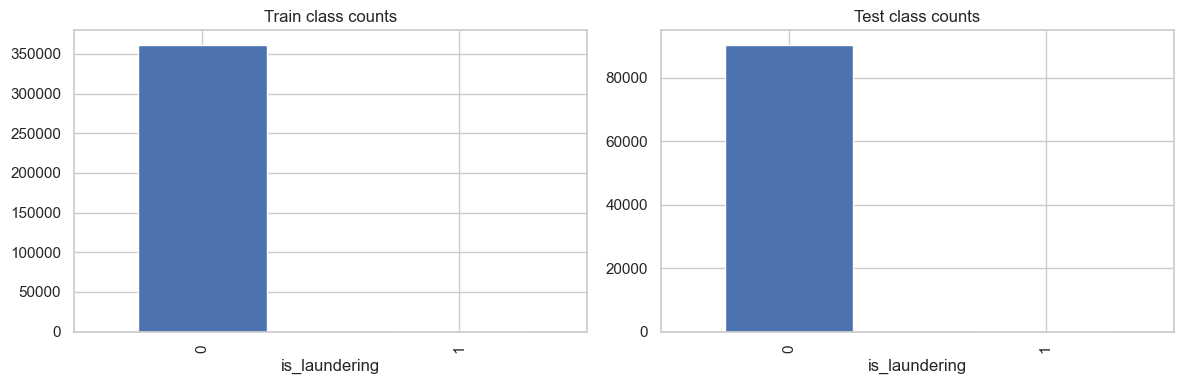

In [ ]:
# 1.a Split into train/test by time (stream split) -- time-based latest 20% for test
# Ensure timestamp exists
if df['timestamp'].isna().any():
    print('Warning: some timestamps could not be parsed; these rows are placed at the beginning when sorting')


df_sorted = df.sort_values('timestamp').reset_index(drop=True)
cutoff_idx = int(0.8 * len(df_sorted))
train = df_sorted.iloc[:cutoff_idx].copy()
test = df_sorted.iloc[cutoff_idx:].copy()


print('\nTrain/Test sizes:', train.shape, test.shape)

# Save to CSV
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

# 1.b Frequency in both sets
print('\nTrain laundering count: {}'.format(train['is_laundering'].sum()))
print('\nTrain laundering rate: {:.4f}%'.format(train['is_laundering'].mean()*100))
print('\nTest laundering count: {}'.format(test['is_laundering'].sum()))
print('\nTest laundering rate: {:.4f}%'.format(test['is_laundering'].mean()*100))

# Plot class balance
fig, ax = plt.subplots(1, 2, figsize=(12,4))
train['is_laundering'].value_counts().plot(kind='bar', ax=ax[0], title='Train class counts')
test['is_laundering'].value_counts().plot(kind='bar', ax=ax[1], title='Test class counts')
plt.tight_layout()

## 2. Network Analysis

### 2. a. Build a graph of accounts (nodes) and transactions (edges)


Top 10 component sizes:
   component_id   size
0             0  14776
1             2   9175
2            11   1852
3             3   1631
4            12   1501
5             5   1483
6             1   1453
7             6   1237
8             4   1188
9            14   1162


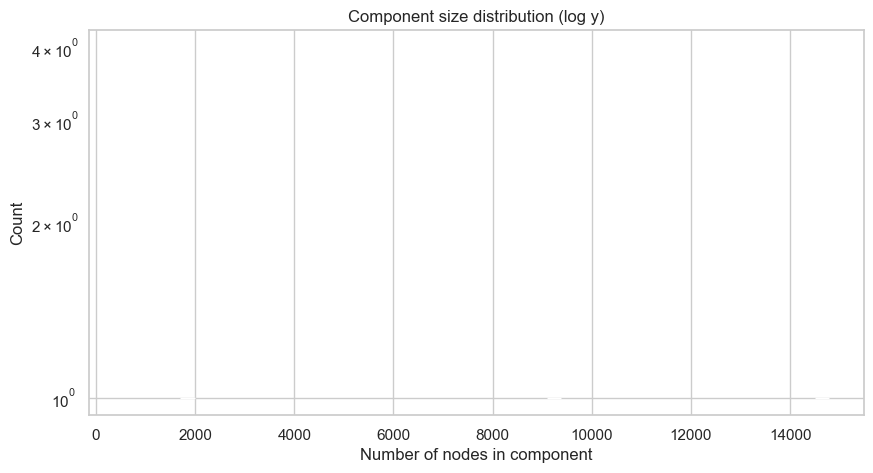

In [ ]:
# %%
# 2. Graph components: bar chart/histogram/table of number of components and their sizes
# Build graph (undirected) where nodes = accounts and edges = transaction
G = nx.DiGraph()


# Use concatenation of bank and account to make unique account id if banks exist
# create node ids
df['from_node'] = df['from_bank'].astype(str) + '|' + df['from_account'].astype(str)
df['to_node'] = df['to_bank'].astype(str) + '|' + df['to_account'].astype(str)


# add edges
for idx, row in df.iterrows():
    u = row['from_node']
    v = row['to_node']
    amt = row['amount']
    G.add_node(u)
    G.add_node(v)
    # store list of transaction indices in edge attributes (for traceability)
    if G.has_edge(u, v):
        G[u][v]['weight'] += 1
        G[u][v]['amounts'].append(amt)
        G[u][v]['tx_indices'].append(idx)
    else:
        G.add_edge(u, v, weight=1, amounts=[amt], tx_indices=[idx])


# Connected components (consider undirected components to find connected groups)
G_und = G.to_undirected()
components = list(nx.connected_components(G_und))
comp_sizes = [len(c) for c in components]


comp_df = pd.DataFrame({'component_id': range(len(components)), 'size': comp_sizes})
comp_df = comp_df.sort_values('size', ascending=False).reset_index(drop=True)


# Plot histogram of component sizes
plt.figure(figsize=(10,5))
sns.histplot(comp_df['size'], bins=50, log_scale=(False, True))
plt.title('Component size distribution (log y)')
plt.xlabel('Number of nodes in component')


# Table: top components
print('\nTop 10 component sizes:')
print(comp_df.head(10))

In [ ]:
len(G.nodes()) -> 39735
len(G.edges()) -> 39721
G.is_directed() -> True

In [ ]:
len(comp_df)

15

Having distinct components is due to the fact that we are only looking at a single bank. The cycles through which money becomes integrated into the financial systes often involves multiple banks. So due to the banks limited view these components become disconnected.

In [ ]:
#cell1
# %%
# 9. Network Analysis (expanded)
# 9.a Node & edge attributes
# Compute node degrees and weighted degrees
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
weighted_in = {n: sum([d['weight'] for _,_,d in G.in_edges(n, data=True)]) for n in G.nodes()}
weighted_out = {n: sum([d['weight'] for _,_,d in G.out_edges(n, data=True)]) for n in G.nodes()}


nx.set_node_attributes(G, in_degrees, 'in_degree')
nx.set_node_attributes(G, out_degrees, 'out_degree')
nx.set_node_attributes(G, weighted_in, 'weighted_in')
nx.set_node_attributes(G, weighted_out, 'weighted_out')


# Centrality measures
pagerank = nx.pagerank(G, alpha=0.85)
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)


nx.set_node_attributes(G, pagerank, 'pagerank')
nx.set_node_attributes(G, degree_centrality, 'deg_centrality')
nx.set_node_attributes(G, betweenness, 'betweenness')


# Reciprocity: fraction of reciprocal edges for each node
recip = {}
for n in G.nodes():
    out_neighbors = set(G.successors(n))
    in_neighbors = set(G.predecessors(n))
    if len(out_neighbors) + len(in_neighbors) == 0:
        recip[n] = 0
    else:
        recip[n] = len(out_neighbors & in_neighbors) / max(1, len(out_neighbors | in_neighbors))


nx.set_node_attributes(G, recip, 'reciprocity')


# 9.b Community detection (greedy modularity)
from networkx.algorithms import community
communities = list(community.greedy_modularity_communities(G_und))
print('\nNumber of communities found:', len(communities))


# Map node to community id
node_community = {}
for i, comm in enumerate(communities):
    for n in comm:
        node_community[n] = i


# Attach community id to nodes
nx.set_node_attributes(G, node_community, 'community')


# Are certain communities overrepresented in laundering?
# Create mapping from node->community and transaction->community (from_node's community)
node_comm_df = pd.DataFrame.from_dict({n: G.nodes[n] for n in G.nodes()}, orient='index')
node_comm_df = node_comm_df.reset_index().rename(columns={'index':'node'})


# merge community id back to transactions using from_node
node_comm_df_small = node_comm_df[['node','community']]
df = df.merge(node_comm_df_small.rename(columns={'node':'from_node'}), on='from_node', how='left')
comm_rates = df.groupby('community')['is_laundering'].agg(['count','mean']).sort_values('count',ascending=False)
print('\nTop communities by transactions with laundering rate:')
print(comm_rates.head(20))


# Inspect suspicious communities (high laundering rate)
suspicious_comm = comm_rates[comm_rates['mean'] > (df['is_laundering'].mean()*5)]
print('\nSuspicious communities (laundering rate >> global):')
print(suspicious_comm)


# Save a small subgraph for inspection: top community by laundering rate
if len(suspicious_comm) > 0:
    top_comm_id = suspicious_comm.sort_values('mean',ascending=False).index[0]
    nodes_in_top_comm = [n for n,d in G.nodes(data=True) if d.get('community')==top_comm_id]
    subG = G.subgraph(nodes_in_top_comm).copy()
    print('Top suspicious community node count:', subG.number_of_nodes(), 'edges:', subG.number_of_edges())


Number of communities found: 15

Top communities by transactions with laundering rate:
            count      mean
community                  
0          169756  0.001431
1          103671  0.001524
2           20647  0.001405
3           18771  0.001119
5           17381  0.001208
4           16926  0.000768
6           16540  0.001572
7           14277  0.001121
8           13854  0.001660
9           13101  0.001374
10          12420  0.001288
11          11083  0.001263
12           9519  0.001366
13           8337  0.001559
14           6468  0.001391

Suspicious communities (laundering rate >> global):
Empty DataFrame
Columns: [count, mean]
Index: []


In [4]:
#cell2
# Collect all unique node and edge attribute names
node_attrs = set()
for _, data in G.nodes(data=True):
    node_attrs.update(data.keys())

print("Node attributes:", node_attrs)

edge_attrs = set()
for _, _, data in G.edges(data=True):
    edge_attrs.update(data.keys())

print("Edge attributes:", edge_attrs)

print("Example node data:", list(G.nodes(data=True))[:3])
print("Example edge data:", list(G.edges(data=True))[:3])

Node attributes: {'deg_centrality', 'betweenness', 'weighted_out', 'out_degree', 'reciprocity', 'weighted_in', 'community', 'pagerank', 'in_degree'}
Edge attributes: {'amounts', 'tx_indices', 'weight'}
Example node data: [('70|100428660', {'in_degree': 545, 'out_degree': 14230, 'weighted_in': 1084, 'weighted_out': 168672, 'pagerank': 0.011312606805390878, 'deg_centrality': 0.37184778778879546, 'betweenness': 0.004912332528643646, 'reciprocity': 0.0, 'community': 0}), ('10|800059F50', {'in_degree': 1, 'out_degree': 0, 'weighted_in': 21, 'weighted_out': 0, 'pagerank': 2.4959224295188426e-05, 'deg_centrality': 2.516736296370866e-05, 'betweenness': 0.0, 'reciprocity': 0.0, 'community': 0}), ('220|800132390', {'in_degree': 1, 'out_degree': 0, 'weighted_in': 3, 'weighted_out': 0, 'pagerank': 2.389948881858077e-05, 'deg_centrality': 2.516736296370866e-05, 'betweenness': 0.0, 'reciprocity': 0.0, 'community': 0})]
Example edge data: [('70|100428660', '10|800059F50', {'weight': 21, 'amounts': [5

Add edge attribute for 'is_laundering', payment_format and currencies

In [11]:
for u, v, data in G.edges(data=True):
    # Get the indices of transactions on this edge
    tx_idx = data['tx_indices']
    
    # Extract the target labels from your original dataframe
    data['is_laundering'] = int(df.loc[tx_idx, 'is_laundering'].any())
    # or fraction of laundering transactions: 
    # data['laundering_rate'] = df.loc[tx_idx, 'Is Laundering'].mean()
    # any() → marks the edge as suspicious if any transaction is laundering.
    # mean() → gives the proportion of laundering transactions, useful for weighting.

    # Payment types
    data['payment_formats'] = df.loc[tx_idx, 'payment_format'].tolist()

    # Currencies
    data['currencies'] = df.loc[tx_idx, 'currency'].tolist()

Add node attribute for 'is_suspicious'

In [ ]:
for node in G.nodes():
    # Get all in/out edges involving this node
    edges = list(G.in_edges(node, data=True)) + list(G.out_edges(node, data=True))
    n_edges = len(edges)

    if n_edges == 0:
        G.nodes[node]['is_suspicious'] = 0
        G.nodes[node]['suspicious_weight'] = 0.0
        continue

    # Count laundering edges
    laundering_count = sum(edge_data['is_laundering'] for _, _, edge_data in edges)

    # Compute proportion
    suspicious_ratio = laundering_count / n_edges

    # Apply rules for suspicious accounts
    if n_edges == 1:
        is_suspicious = int(laundering_count == 1)
    else:
        is_suspicious = int(suspicious_ratio > 0.5)

    # Assign attributes
    G.nodes[node]['is_suspicious'] = is_suspicious
    G.nodes[node]['suspicious_weight'] = suspicious_ratio

In [13]:
# sanity check to ensure features have been added to graph

node_attrs = set()
for _, data in G.nodes(data=True):
    node_attrs.update(data.keys())

print("Node attributes:", node_attrs)

edge_attrs = set()
for _, _, data in G.edges(data=True):
    edge_attrs.update(data.keys())

print("Edge attributes:", edge_attrs)

print("Example node data:", list(G.nodes(data=True))[:2])
print("Example edge data:", list(G.edges(data=True))[:2])

Node attributes: {'deg_centrality', 'betweenness', 'weighted_out', 'out_degree', 'reciprocity', 'weighted_in', 'community', 'pagerank', 'in_degree', 'is_suspicious', 'suspicious_weight'}
Edge attributes: {'weight', 'payment_formats', 'is_laundering', 'currencies', 'amounts', 'tx_indices'}
Example node data: [('70|100428660', {'in_degree': 545, 'out_degree': 14230, 'weighted_in': 1084, 'weighted_out': 168672, 'pagerank': 0.011312606805390878, 'deg_centrality': 0.37184778778879546, 'betweenness': 0.004912332528643646, 'reciprocity': 0.0, 'community': 0, 'is_suspicious': 0, 'suspicious_weight': 0.015972927241962774}), ('10|800059F50', {'in_degree': 1, 'out_degree': 0, 'weighted_in': 21, 'weighted_out': 0, 'pagerank': 2.4959224295188426e-05, 'deg_centrality': 2.516736296370866e-05, 'betweenness': 0.0, 'reciprocity': 0.0, 'community': 0, 'is_suspicious': 0, 'suspicious_weight': 0.0})]
Example edge data: [('70|100428660', '10|800059F50', {'weight': 21, 'amounts': [5105.92, 11787.72, 8233.79,

!!IMPORTANT!! Save original graph before changing format of the data into a format suitable for Gephi

In [16]:
#cell3
# Save
with open("bank70_graph_with_features.pkl", "wb") as f:
    pickle.dump(G, f)

Make graph suitable for ghephi

In [17]:
#cell4
for u, v, data in G.edges(data=True):
    data['amounts_str'] = ','.join(map(str, data['amounts']))
    data['tx_indices_str'] = ','.join(map(str, data['tx_indices']))
    data['currencies'] = ','.join(map(str, data['currencies']))
    data['formats'] = ','.join(map(str, data['payment_formats']))

    # Optionally remove original lists to avoid errors
    data.pop('amounts')
    data.pop('tx_indices')
    data.pop('currencies')
    data.pop('payment_formats')

In [18]:
#cell5
nx.write_graphml(G, "bank70_graph.graphml")

Reload original graph to continue with the rest of the notebook

In [3]:
# Load
with open(r"top_bank\bank70_graph_with_features.pkl", "rb") as f:
    G = pickle.load(f)

## 3. Transaction Landscape


Number of unique accounts: 39735
Number of unique banks: 3045

Unique currencies: 15


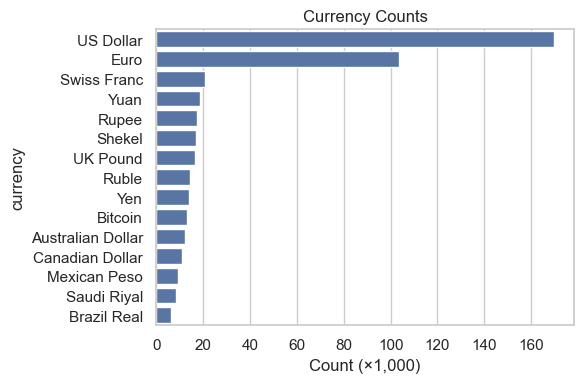

In [20]:
# %%
# 3. Landscape
# 3.a Number of unique accounts
num_unique_accounts = pd.unique(df[['from_account','to_account']].values.ravel()).size
print('\nNumber of unique accounts:', num_unique_accounts)


# 3.b Number of unique banks
num_unique_banks = pd.unique(pd.concat([df['from_bank'], df['to_bank']])).size
print('Number of unique banks:', num_unique_banks)


# 3.c Number of unique currencies and distribution
unique_currencies = df['currency'].nunique()
print('\nUnique currencies:', unique_currencies)

# Distribution
#fig, ax = plt.subplots(1,2, figsize=(12,4))
#sns.countplot(data=df, y='currency', order=df['currency'].value_counts().index, ax=ax[0])
#ax[0].set_title('Currency counts')

fig, ax = plt.subplots(figsize=(6, 4))  # smaller single plot

sns.countplot(
    data=df,
    y='currency',
    order=df['currency'].value_counts().index,
    ax=ax
)

ax.set_title('Currency Counts')
ax.set_xlabel('Count (×1,000)')

# Scale x-axis ticks to show thousands
x_labels = ax.get_xticks()
ax.set_xticklabels([f"{int(x/1000)}" for x in x_labels])

plt.tight_layout()
plt.show()

In [21]:
# 3.c.i Rate of laundering by currency
rates = df.groupby('currency')['is_laundering'].agg(['count','mean']).sort_values('count',ascending=False)
print('\nTop currencies by frequency with laundering rate:')
print(rates.head(20))



Top currencies by frequency with laundering rate:
                    count      mean
currency                           
US Dollar          169756  0.001431
Euro               103671  0.001524
Swiss Franc         20647  0.001405
Yuan                18771  0.001119
Rupee               17381  0.001208
Shekel              16926  0.000768
UK Pound            16540  0.001572
Ruble               14277  0.001121
Yen                 13854  0.001660
Bitcoin             13101  0.001374
Australian Dollar   12420  0.001288
Canadian Dollar     11083  0.001263
Mexican Peso         9519  0.001366
Saudi Riyal          8337  0.001559
Brazil Real          6468  0.001391



Payment format counts:
payment_format
Cheque         213698
Credit Card    134680
Cash            91272
Bitcoin         13101
Name: count, dtype: int64


Text(0.5, 1.0, 'Payment format distribution')

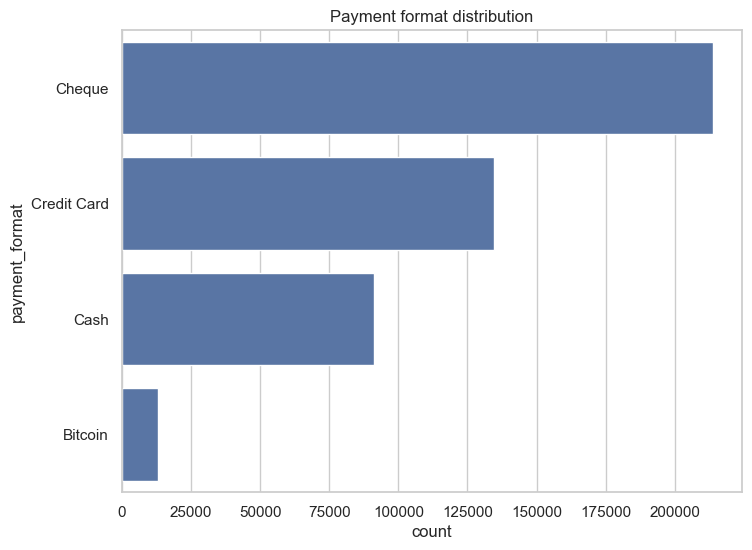

In [22]:
# 3.d Number of unique payment types and distribution
print('\nPayment format counts:')
print(df['payment_format'].value_counts().head(20))
plt.figure(figsize=(8,6))
sns.countplot(y='payment_format', data=df, order=df['payment_format'].value_counts().index)
plt.title('Payment format distribution')

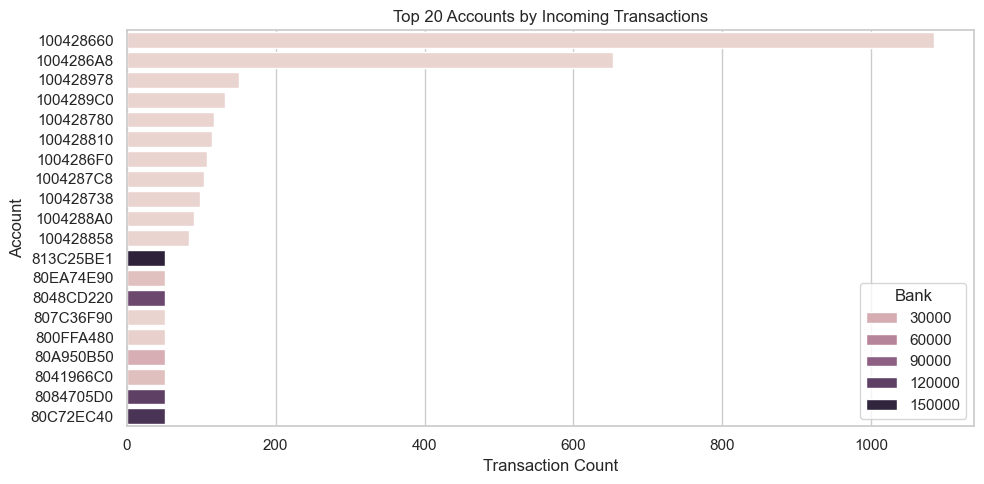

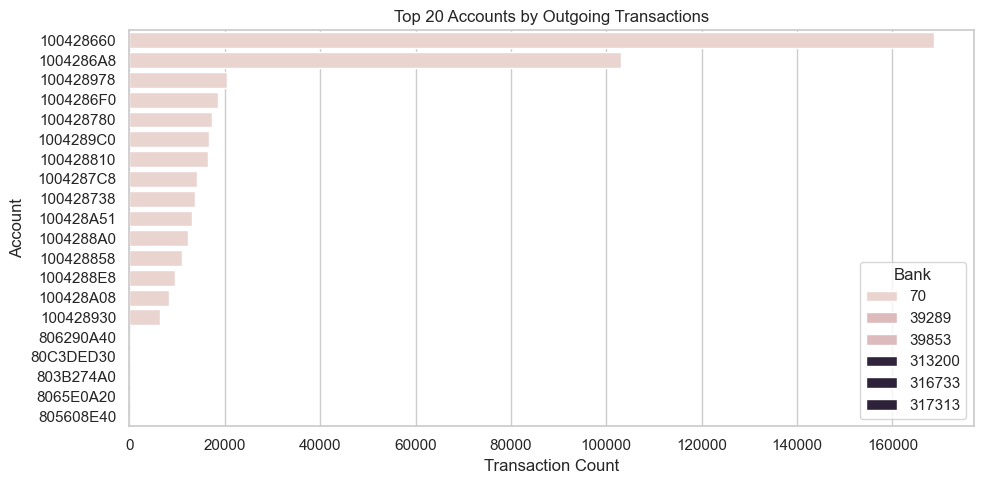

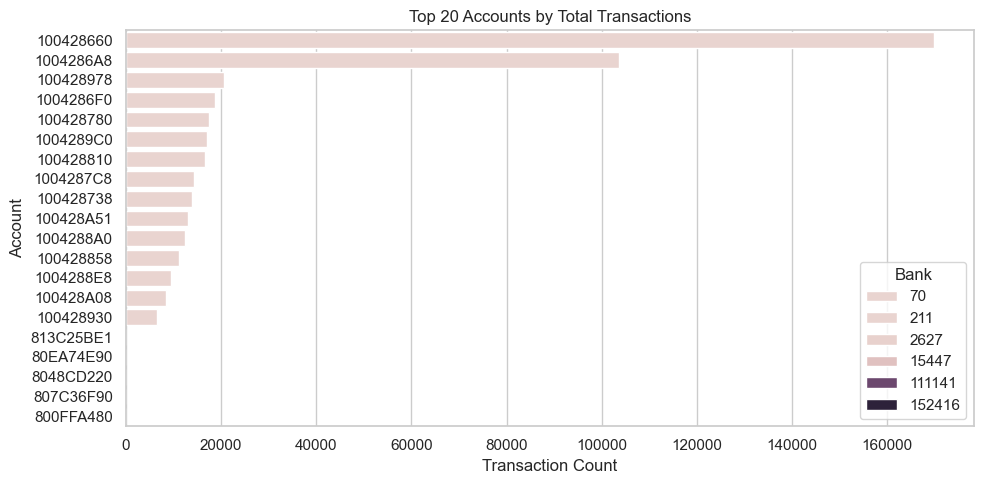

In [27]:
# Compute in and out counts
in_counts = df['to_account'].value_counts().rename('in_count')
out_counts = df['from_account'].value_counts().rename('out_count')

# Merge them
acct_counts = pd.concat([in_counts, out_counts], axis=1).fillna(0)
acct_counts['total_count'] = acct_counts['in_count'] + acct_counts['out_count']

# Add bank info (assuming 'From Bank' and 'To Bank' align with accounts)
acct_to_bank = pd.concat([
    df[['from_account', 'from_bank']].rename(columns={'from_account': 'account', 'from_bank': 'bank'}),
    df[['to_account', 'to_bank']].rename(columns={'to_account': 'account', 'to_bank': 'bank'})
]).drop_duplicates('account')
acct_counts = acct_counts.merge(acct_to_bank, left_index=True, right_on='account', how='left')

# Plot top 20 by each metric
for col, title in [('in_count', 'Top 20 Accounts by Incoming Transactions'),
                   ('out_count', 'Top 20 Accounts by Outgoing Transactions'),
                   ('total_count', 'Top 20 Accounts by Total Transactions')]:
    top20 = acct_counts.nlargest(20, col)
    plt.figure(figsize=(10,5))
    sns.barplot(data=top20, x=col, y='account', hue='bank', dodge=False)
    plt.title(title)
    plt.xlabel('Transaction Count')
    plt.ylabel('Account')
    plt.legend(title='Bank')
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'Transaction frequency per account (log x)')

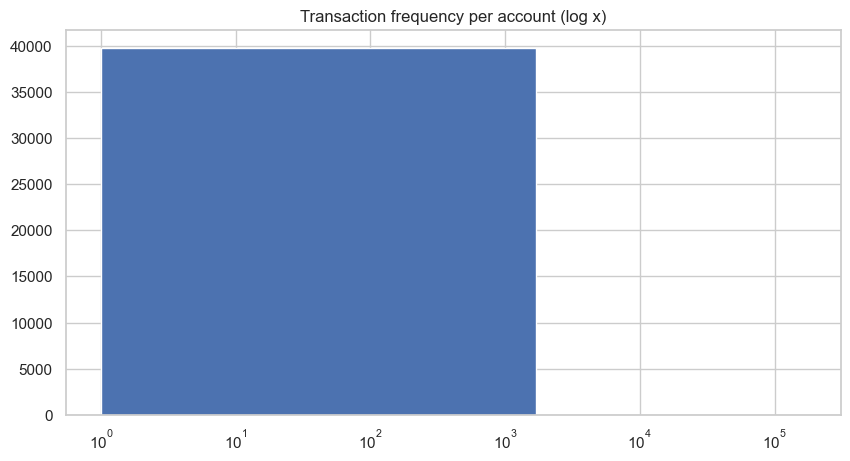

In [ ]:
# 3.e Transaction frequency per account (log scale)
acct_counts = pd.concat([df['from_account'], df['to_account']]).value_counts()
plt.figure(figsize=(10,5))
acct_counts_hist = acct_counts.hist(bins=100)
plt.xscale('log')
plt.title('Transaction frequency per account (log x)')

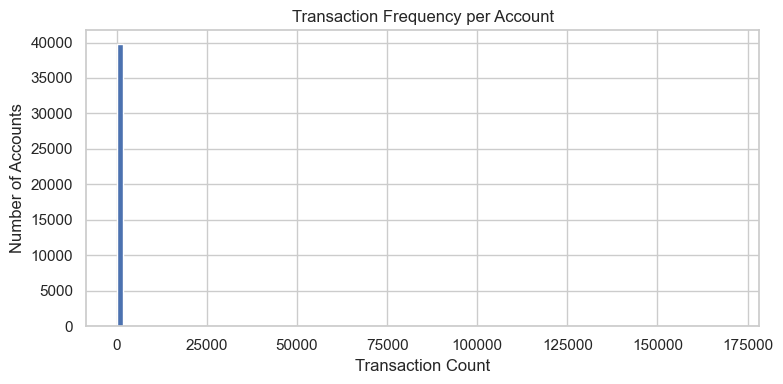

In [28]:
plt.figure(figsize=(8,4))
plt.hist(acct_counts['total_count'], bins=100)
plt.title('Transaction Frequency per Account')
plt.xlabel('Transaction Count')
plt.ylabel('Number of Accounts')
plt.tight_layout()
plt.show()

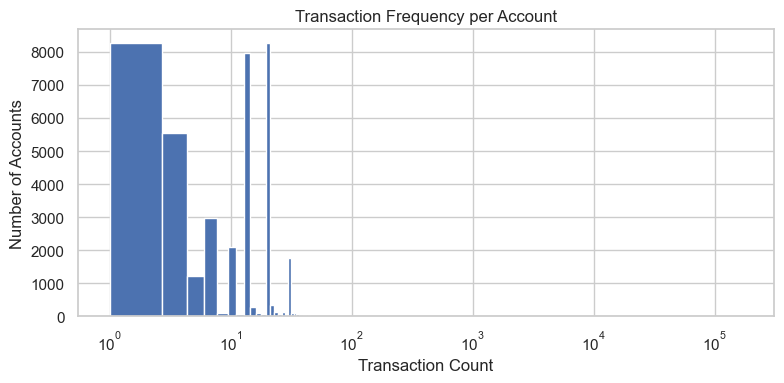

In [34]:
plt.figure(figsize=(8,4))
plt.hist(acct_counts['total_count'], bins=100000)
plt.xscale('log')
plt.title('Transaction Frequency per Account')
plt.xlabel('Transaction Count')
plt.ylabel('Number of Accounts')
plt.tight_layout()
plt.show()

## 4. Categorical Features

In [35]:
# 4. Categorical features
cat_cols = ['from_bank','to_bank','payment_format','currency']


# 4.a Frequency tables
for c in cat_cols:
    print('\nTop values for', c)
    print(df[c].value_counts().head(5))


# 4.b Laundering rate by category
for c in cat_cols:
    rates = df.groupby(c)['is_laundering'].agg(['count','mean']).sort_values('count',ascending=False)
    print(f"\nLaundering rate by {c} (top 10):")
    print(rates.head(10))


Top values for from_bank
from_bank
70        449859
31903          6
311062         6
3678           6
3533           6
Name: count, dtype: int64

Top values for to_bank
to_bank
12     3920
10     3730
15     3504
70     2892
220    2874
Name: count, dtype: int64

Top values for payment_format
payment_format
Cheque         213698
Credit Card    134680
Cash            91272
Bitcoin         13101
Name: count, dtype: int64

Top values for currency
currency
US Dollar      169756
Euro           103671
Swiss Franc     20647
Yuan            18771
Rupee           17381
Name: count, dtype: int64

Laundering rate by from_bank (top 10):
            count      mean
from_bank                  
70         449859  0.001407
3533            6  0.000000
3678            6  0.000000
38705           6  0.000000
31903           6  0.000000
311062          6  0.000000
3228            4  0.000000
3358            4  0.000000
3236            4  0.000000
3262            4  0.000000

Laundering rate by to_bank (

In [39]:
# 4.c Feature relevance: chi-square / mutual information
# Prepare for mutual info: encode categorical columns
encoders = {}
df_enc = df.copy()
for c in cat_cols:
    df_enc[c] = df_enc[c].fillna('MISSING')
    le = LabelEncoder()
    df_enc[c] = le.fit_transform(df_enc[c].astype(str))
    encoders[c] = le


# Mutual information (works with discrete features)
mi = mutual_info_classif(df_enc[cat_cols].fillna(-1), df_enc['is_laundering'].fillna(0), discrete_features=True)
mi_df = pd.DataFrame({'feature':cat_cols, 'mutual_info':mi}).sort_values('mutual_info', ascending=False)
print('\nMutual information scores:')
print(mi_df)


Mutual information scores:
          feature  mutual_info
1         to_bank     0.001372
3        currency     0.000012
0       from_bank     0.000009
2  payment_format     0.000005


In [41]:
# Chi-square tests for each categorical (pivot into contingency table for top categories only)
from scipy.stats import chi2_contingency
for c in cat_cols:
    print('\nChi-square for', c)
    top = df[c].fillna('MISSING').value_counts().nlargest(20).index
    ct = pd.crosstab(df[c].fillna('MISSING'), df['is_laundering']).loc[top]
    try:
        chi2, p, dof, ex = chi2_contingency(ct + 0.0001)
        print('chi2 p-value:', p)
    except Exception as e:
        print('chi2 error', e)


Chi-square for from_bank
chi2 p-value: 1.0

Chi-square for to_bank
chi2 p-value: 0.20219810897777205

Chi-square for payment_format
chi2 p-value: 0.19464405003359708

Chi-square for currency
chi2 p-value: 0.771572389163607


In [37]:
# Self cycles: identical from and to accounts
df['self_cycle'] = df['from_account'] == df['to_account']
print('\nNumber of self-cycle transactions:', df['self_cycle'].sum())
print('Self-cycle laundering rate:', df[df['self_cycle']]['is_laundering'].mean())


Number of self-cycle transactions: 0
Self-cycle laundering rate: nan



Z-score outliers count (amount): 395
Outlier laundering rate: 0.0
IQR outliers count: 77617
IQR outlier laundering rate: 0.0012368424443098805


<Figure size 1000x500 with 0 Axes>

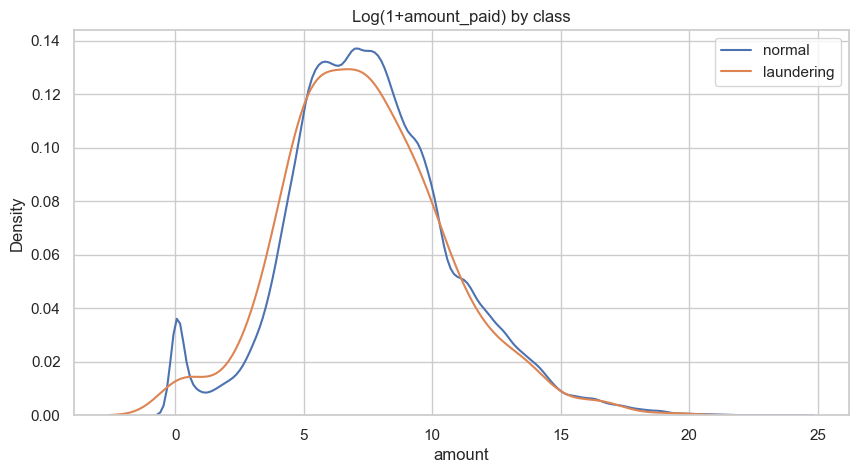

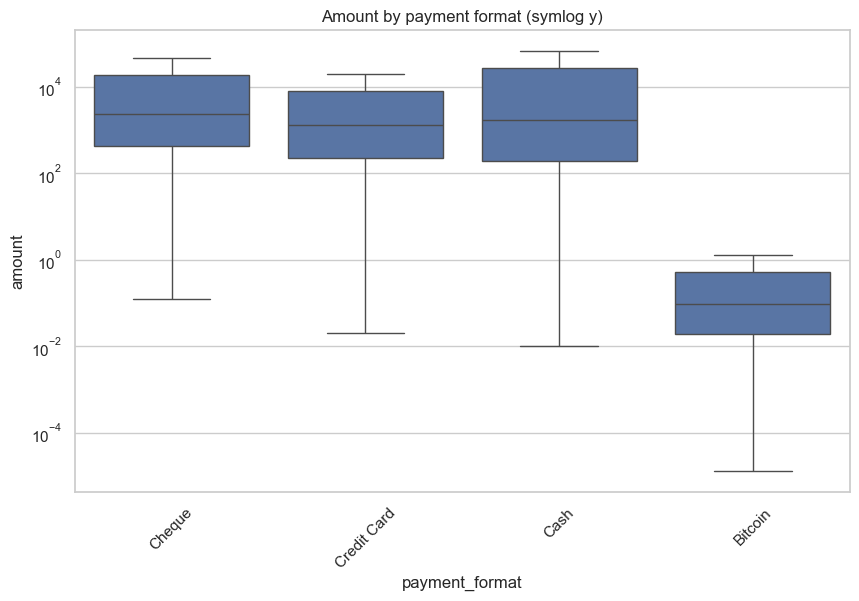

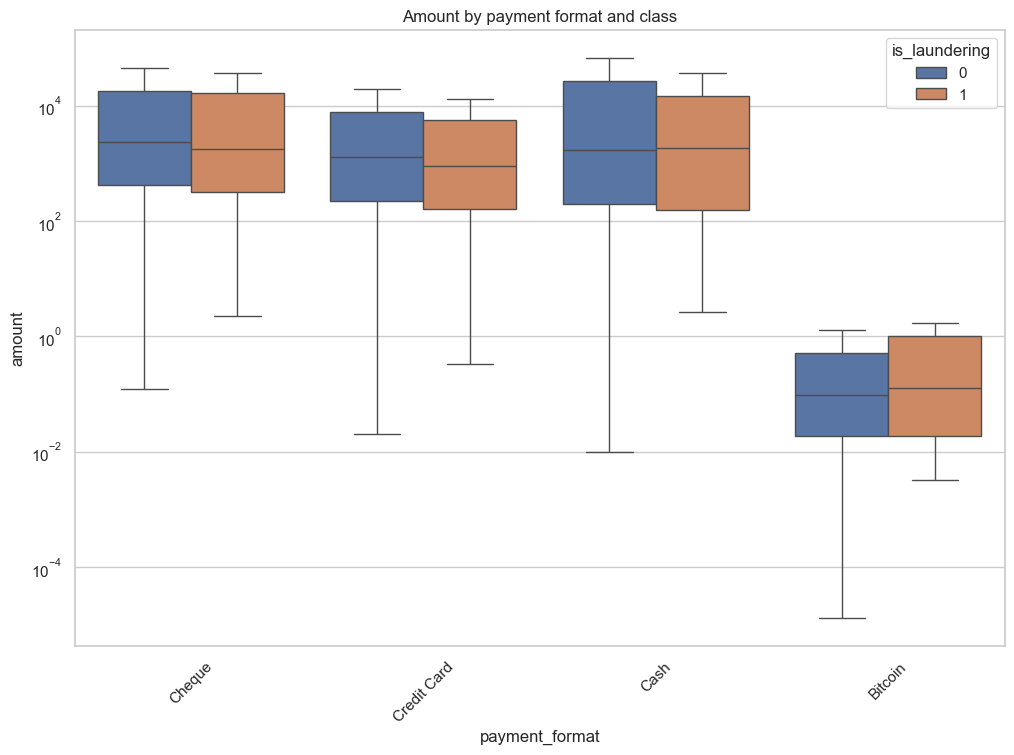

In [38]:
# %%
plt.tight_layout()


# 6.b Compare laundering vs normal (log scale)
plt.figure(figsize=(10,5))
sns.kdeplot(np.log1p(df[df['is_laundering']==0]['amount'].dropna()), label='normal')
sns.kdeplot(np.log1p(df[df['is_laundering']==1]['amount'].dropna()), label='laundering')
plt.title('Log(1+amount_paid) by class')
plt.legend()


# 6.c Boxplots by payment format
plt.figure(figsize=(10,6))
sns.boxplot(x='payment_format', y='amount', data=df[df['amount'].notna() & df['payment_format'].notna()], showfliers=False)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Amount by payment format (symlog y)')


# 6.c.i Boxplots comparing laundering vs not per payment_format
plt.figure(figsize=(12,8))
sns.boxplot(x='payment_format', y='amount', hue='is_laundering', data=df[df['amount'].notna() & df['payment_format'].notna()], showfliers=False)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Amount by payment format and class')


# 6.d Detect statistical anomalies in amounts
# Approach: flag outliers using z-score and IQR
amounts = df['amount'].dropna()
z_scores = np.abs(stats.zscore(amounts))
# align back to index
z_series = pd.Series(index=amounts.index, data=z_scores)


z_outliers = z_series[z_series > 3]
print('\nZ-score outliers count (amount):', len(z_outliers))
print('Outlier laundering rate:', df.loc[z_outliers.index, 'is_laundering'].mean())


# IQR method
q1 = amounts.quantile(0.25)
q3 = amounts.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
iqr_out = df[(df['amount'] < lower) | (df['amount'] > upper)]
print('IQR outliers count:', len(iqr_out))
print('IQR outlier laundering rate:', iqr_out['is_laundering'].mean())

### Feature interactions

In [ ]:
# %%
# 8. Feature interactions & how to determine which features to drop
# Approaches provided as code examples:
# - VIF for numerical values (on nodes this is centrality measures)
# - Mutual information / chi-square for categorical
# - Model-based importances (RandomForest)


# Model-based importance example: using simple encoding and RandomForest
fea = ['amount'] + cat_cols
sample = df[fea + ['is_laundering']].dropna().sample(min(20000, len(df)))
# encode categorical with label encoder (simple)
for c in cat_cols:
    sample[c] = sample[c].astype(str)
    sample[c] = encoders[c].transform(sample[c])


X = sample[fea]
y = sample['is_laundering']
clf = RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1, random_state=42)
clf.fit(X, y)
importances = pd.Series(clf.feature_importances_, index=fea).sort_values(ascending=False)
print('\nRandomForest feature importances:')
print(importances)


Numeric correlation:
        amount
amount     1.0

RandomForest feature importances:
amount            0.703955
to_bank           0.233218
currency          0.032736
payment_format    0.030056
from_bank         0.000035
dtype: float64


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Collect node attributes
node_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

# Select numeric centrality features
features = ['pagerank', 'betweenness', 'deg_centrality', 'in_degree',
            'out_degree', 'weighted_in', 'weighted_out']
X = node_df[features].fillna(0)

# Compute VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df.sort_values('VIF', ascending=False))

          feature           VIF
2  deg_centrality           inf
4      out_degree           inf
3       in_degree           inf
6    weighted_out  1.802855e+04
0        pagerank  2.684514e+02
1     betweenness  1.829184e+01
5     weighted_in  3.456135e+00


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Correlation with suspicious weight
corrs = node_df[features + ['suspicious_weight']].corr()['suspicious_weight'].sort_values(ascending=False)
print("Correlation with suspicious weight:\n", corrs)

# Logistic regression for binary is_suspicious
y = node_df['is_suspicious'].astype(int)
X = node_df[features].fillna(0)

model = LogisticRegression(max_iter=500)
model.fit(X, y)
importances = pd.Series(model.coef_[0], index=features)
print("\nFeature importance (logistic coefficients):\n", importances.sort_values(ascending=False))

print("AUC:", roc_auc_score(y, model.predict_proba(X)[:,1]))

Correlation with suspicious weight:
 suspicious_weight    1.000000e+00
weighted_in          7.541861e-02
in_degree            1.401464e-03
pagerank             6.970770e-04
betweenness          2.597969e-05
deg_centrality      -2.650066e-08
weighted_out        -8.683643e-06
out_degree          -5.338720e-05
Name: suspicious_weight, dtype: float64

Feature importance (logistic coefficients):
 weighted_in       7.560141e-02
betweenness       1.138132e-08
pagerank         -7.529954e-05
deg_centrality   -7.826757e-05
out_degree       -1.205074e+00
weighted_out     -1.765674e+00
in_degree        -1.904809e+00
dtype: float64
AUC: 0.7143566546365001


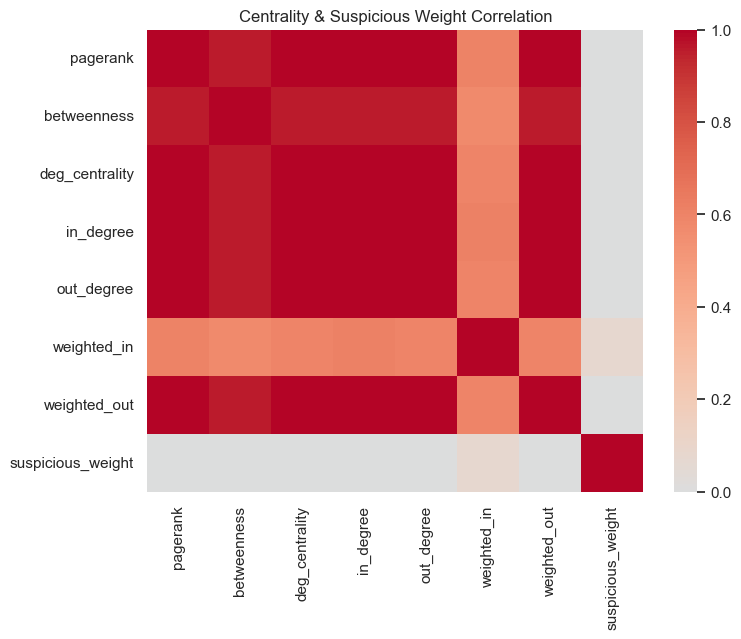

In [55]:
plt.figure(figsize=(8,6))
sns.heatmap(node_df[features + ['suspicious_weight']].corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Centrality & Suspicious Weight Correlation")
plt.show()

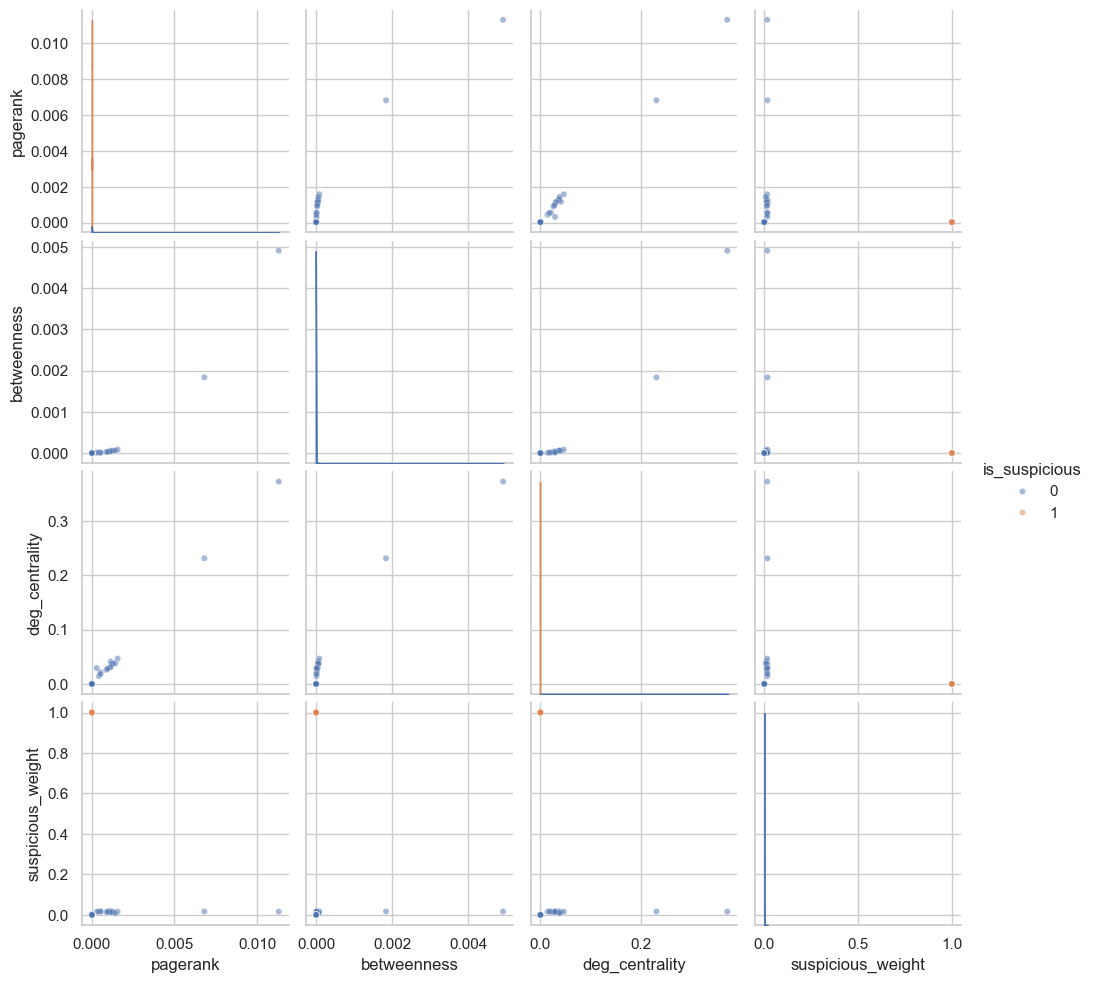

In [56]:
sns.pairplot(node_df, vars=['pagerank', 'betweenness', 'deg_centrality', 'suspicious_weight'],
             hue='is_suspicious', plot_kws={'alpha':0.5, 's':20})


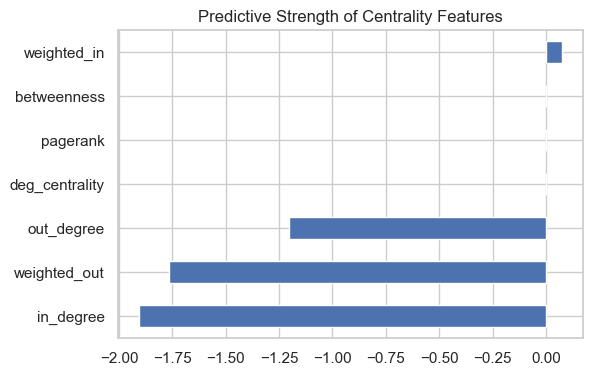

In [57]:
importances.sort_values().plot(kind='barh', figsize=(6,4), title="Predictive Strength of Centrality Features")
plt.show()

## 5. Time series Analysis

Data covers: 2022-09-01 00:00:00 to 2022-09-10 23:59:00


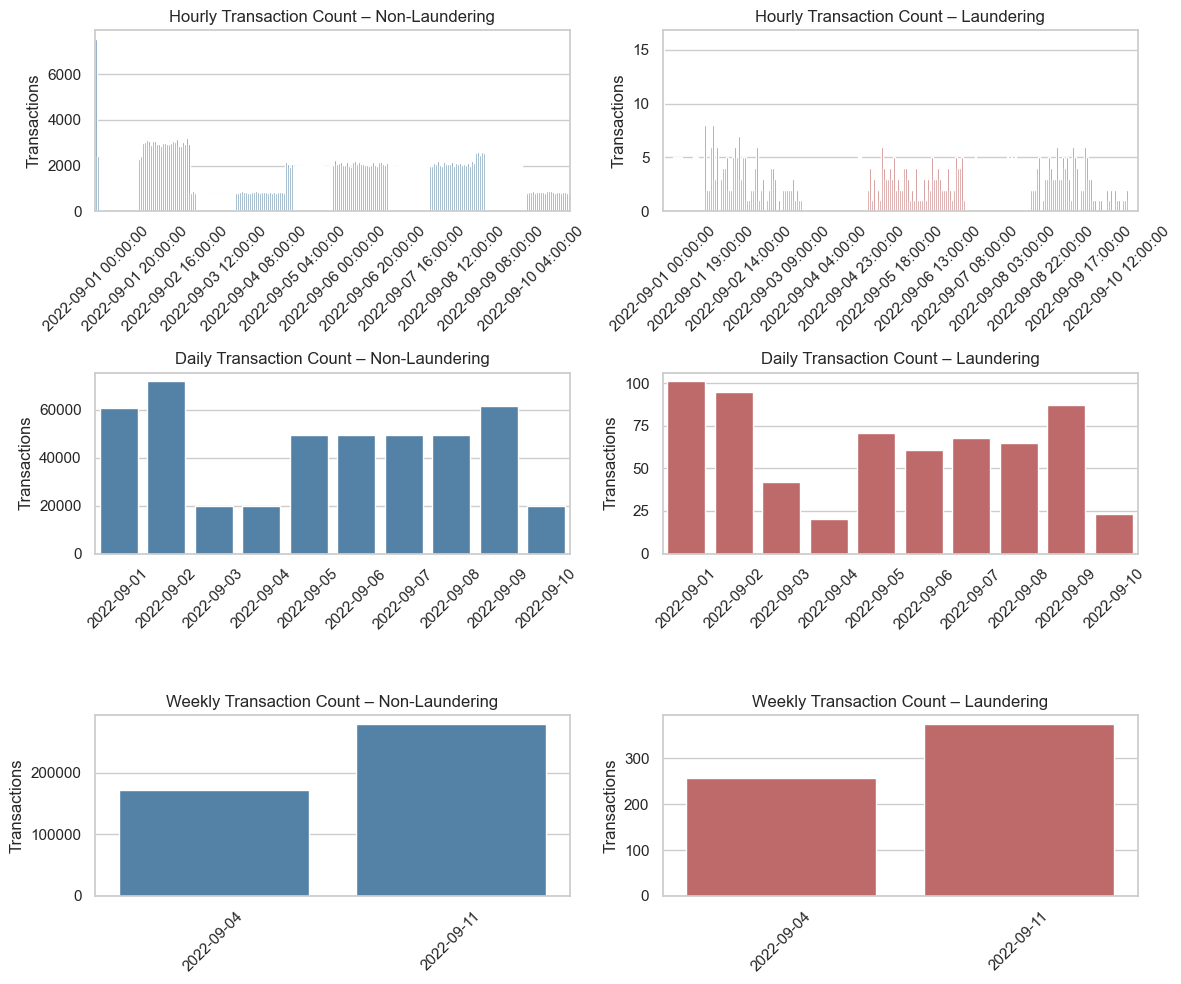

In [44]:
# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_time = df.set_index('timestamp')

# --- Show overall timespan ---
print("Data covers:", df_time.index.min(), "to", df_time.index.max())

# --- Masks ---
laund_mask = df_time['is_laundering'] == 1
non_laund_mask = ~laund_mask

# --- Aggregations ---
def agg_counts(freq):
    return {
        'laund': df_time[laund_mask].resample(freq)['amount'].agg(['count', 'sum']),
        'non_laund': df_time[non_laund_mask].resample(freq)['amount'].agg(['count', 'sum'])
    }

agg = {f: agg_counts(f) for f in ['H', 'D', 'W']}  # Hourly, Daily, Weekly

# --- Plotting ---
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=False)
fig.subplots_adjust(hspace=0.4)
freq_labels = ['Hourly', 'Daily', 'Weekly']

for i, freq in enumerate(['H', 'D', 'W']):
    for j, (key, label) in enumerate(zip(['non_laund', 'laund'], ['Non-Laundering', 'Laundering'])):
        ax = axes[i, j]
        sns.barplot(x=agg[freq][key].index, y='count', data=agg[freq][key].reset_index(), ax=ax, color='steelblue' if key=='non_laund' else 'indianred')
        ax.set_title(f"{freq_labels[i]} Transaction Count – {label}")
        ax.set_xlabel('')
        ax.set_ylabel('Transactions')
        if freq == 'H':
            # Make x labels readable for hourly plots
            data = agg[freq][key].reset_index()
            n = max(1, len(data) // 12)   # roughly one tick per day
            ax.set_xticks(ax.get_xticks()[::n])
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
        else:
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)


plt.tight_layout()
plt.show()


In [48]:
print(df_time.columns)

Index(['txn_id', 'from_bank', 'from_account', 'to_bank', 'to_account',
       'amount', 'currency', 'payment_format', 'is_laundering', 'self_cycle'],
      dtype='object')


In [49]:
from scipy.stats import entropy

#df_time = df_time.sort_values('timestamp')
#df_time['timestamp'] = pd.to_datetime(df_time['timestamp'])

hourly = (
    df_time
    .groupby('is_laundering')
    .resample('H')
    .size()
    .rename('count')
    .reset_index()
)

from scipy.signal import periodogram

def temporal_stats(series, timestamps):
    """Compute cycle strength, entropy, burstiness, and variability"""
    if len(series) < 5:
        return None

    # --- Regularity (autocorrelation & FFT) ---
    acf = np.correlate(series - np.mean(series), series - np.mean(series), mode='full')
    acf = acf[acf.size//2:]
    autocorr_strength = acf[1] / acf[0] if acf[0] != 0 else 0

    freqs, psd = periodogram(series)
    dominant_period = 1 / freqs[np.argmax(psd[1:])+1] if len(freqs) > 1 else np.nan

    # --- Entropy of hourly distribution ---
    prob = series / series.sum() if series.sum() > 0 else np.ones_like(series) / len(series)
    timing_entropy = entropy(prob)

    # --- Burstiness (coefficient of variation) ---
    cv = np.std(series) / np.mean(series) if np.mean(series) != 0 else np.nan

    # --- Amplitude / variability ---
    amplitude = series.max() - series.min()

    return {
        'autocorr_strength': autocorr_strength,
        'dominant_period': dominant_period,
        'entropy': timing_entropy,
        'burstiness_cv': cv,
        'amplitude': amplitude
    }

stats = {}
for label, grp in hourly.groupby('is_laundering'):
    stats[label] = temporal_stats(grp['count'].values, grp.index)
       
pd.DataFrame(stats)

,0,1
autocorr_strength,0.777755,0.331599
dominant_period,80.000000,79.666667
entropy,5.385062,5.179596
burstiness_cv,0.435208,0.762397
amplitude,6787.000000,16.000000


In [51]:
def intra_arrival_stats(df, label, n_samples=10):
    subset = df[df['is_laundering']==label]
    accounts = subset['from_account'].value_counts().head(n_samples).index
    stats_list = []

    for acct in accounts:
        tx_times = subset.loc[subset['from_account']==acct].index.sort_values()
        deltas = tx_times.to_series().diff().dt.total_seconds().dropna()
        if len(deltas) > 1:
            stats_list.append({
                'account': acct,
                'label': label,
                'mean_gap_s': deltas.mean(),
                'median_gap_s': deltas.median(),
                'std_gap_s': deltas.std(),
                'cv_gap': deltas.std()/deltas.mean() if deltas.mean() != 0 else np.nan
            })
    return pd.DataFrame(stats_list)

intra_laund = intra_arrival_stats(df_time, 1)
intra_nonlaund = intra_arrival_stats(df_time, 0)

intra_laund
intra_nonlaund

,account,label,mean_gap_s,median_gap_s,std_gap_s,cv_gap
0,100428660,0,5.129432,0.0,16.807215,3.276623
1,1004286A8,0,8.399265,0.0,21.160396,2.519315
2,100428978,0,42.202570,0.0,59.221268,1.403262
3,1004286F0,0,46.346226,60.0,63.576878,1.371781
4,100428780,0,50.099756,60.0,67.458107,1.346476
5,1004289C0,0,51.486293,60.0,71.442666,1.387606
6,100428810,0,52.667846,60.0,70.654935,1.341519
7,1004287C8,0,61.004450,60.0,80.286871,1.316082
8,100428738,0,62.914361,60.0,86.156899,1.369431
9,100428A51,0,66.172821,60.0,91.660288,1.385165


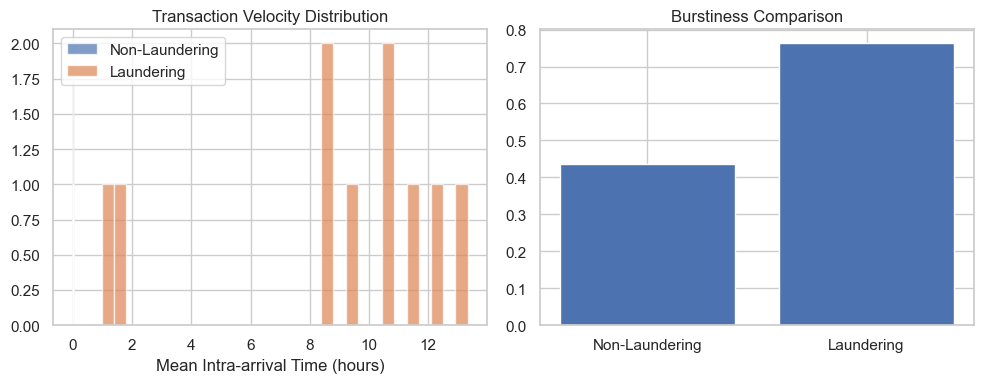

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(intra_nonlaund['mean_gap_s']/3600, bins=30, alpha=0.7, label='Non-Laundering')
ax[0].hist(intra_laund['mean_gap_s']/3600, bins=30, alpha=0.7, label='Laundering')
ax[0].set_xlabel('Mean Intra-arrival Time (hours)')
ax[0].legend()
ax[0].set_title('Transaction Velocity Distribution')

ax[1].bar(['Non-Laundering','Laundering'], [stats[0]['burstiness_cv'], stats[1]['burstiness_cv']])
ax[1].set_title('Burstiness Comparison')
plt.tight_layout()
plt.show()